# Self-Consistent Generalized Langevin Equation

For hard spheres in a monocomponent fluid. The four equatios of the theory are:

\begin{equation}
            \Delta\zeta^*(t)=\frac{D^0}{24\pi^3n}\int_0^\infty d\textbf{k}\Bigg[\frac{k(S(k)-1)}{S(k)}\Bigg]^2F(k,t)F^S(k,t)
        \end{equation}
        \begin{equation}
            F(k,z)=\frac{S(k)}{z+\frac{k^2D^0S^{-1}(k)}{1+\lambda(k)\Delta\zeta^*(z)}}
        \end{equation}
        \begin{equation}
            F^S(k,z)=\frac{1}{z+\frac{k^2D^0}{1+\lambda(k)\Delta\zeta^*(z)}}
        \end{equation}
        \begin{equation}
            \lambda(k)=\frac{1}{1+\Big(\frac{k}{k_c}\Big)^2}
        \end{equation}

Where $\Delta\zeta^*$ is the friction coefficient, $S(k)$ is the structure factor, $n$ is the density, $F$ and $F^s$ are the intermediate scattering functions, $D^0$ is the scattering coefficient, $z$ is the variable corresponding to time in Laplace's space and $k_c$ is a free parameter.

The calculation of the structure factor uses Wertheim's exact solution for Percus-Yevick integral equation.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def calculate_ck(eta, k):
    common_denom = (1.0 - eta)**4
    alpha = -(1.0 + 2.0 * eta)**2.0 / common_denom
    delta = 6.0 * eta * (1.0 + 0.5 * eta)**2 / common_denom
    gamma = -0.5 * eta * alpha
    
    term1 = 4.0 * math.pi / (k**6)
    term2 = alpha * (k**3) * (np.sin(k) - k * np.cos(k)) - 24.0 * gamma
    term3 = (k**2) * (2.0 * k * np.sin(k) - (k**2 - 2.0) * np.cos(k) - 2.0)
    term4 = (4.0 * k**3 - 24.0 * k) * np.sin(k)
    term5 = (k**4 - 12.0 * k**2 + 24.0) * np.cos(k)

    return term1 * (term2 + delta * term3 - gamma * (term4 - term5))

In [3]:
def calculate_sk(eta, k):
    rho = 6.0 * eta / math.pi
    sk = 1.0 / (1.0 - rho * calculate_ck(eta, k))

    return sk

In [4]:
def short_scattering(eta, d0, ks, times):
    grid_time, grid_k = np.meshgrid(times, ks)
    S_k = calculate_sk(eta, grid_k)
    F = S_k * np.exp((-1.0) * (grid_k**2) * d0 * grid_time / S_k)
    F_self = np.exp((-1.0) * (grid_k**2) * d0 * grid_time)
    
    return grid_k, S_k, F, F_self

In [5]:
def friction(d0, density, ks, S_k, F, Fs, dk):
    integrand = F * Fs * ((ks**2) * (S_k - 1.0) / S_k)**2
    integral = np.sum(integrand, 0)
    
    return d0 * integral * dk / (6.0 * math.pi**2 * density)

In [6]:
eta = 0.25 # Volume fraction
dk = 0.01
D0 = 1.0
diameter = 1.0
tolerance = 1.0e-6
delta_t = 1.0e-6
t_steps = 100
kc = 2.0 * math.pi * 1.305 / diameter
rho = 6.0 * eta / math.pi
short_time = np.linspace(1.0e-7, 1.0e-6, 10)
set_of_ks = np.arange(0.01, 41.0, dk)

In [7]:
structure_factor = calculate_sk(eta, set_of_ks)

In [8]:
target0 = np.loadtxt('target.dat', usecols = 0)
target1 = np.loadtxt('target.dat', usecols = 1)

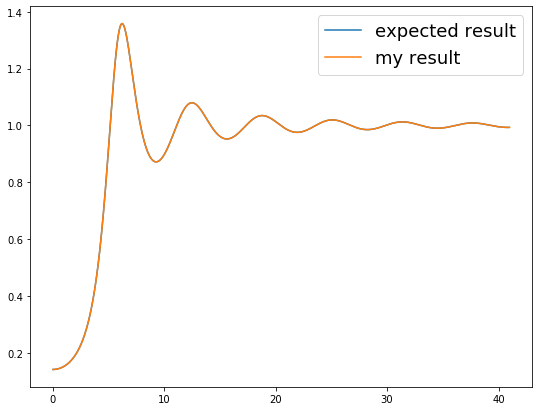

In [9]:
fig = plt.figure(figsize = (9, 7))
fig.add_subplot(1, 1, 1)
plt.plot(target0, target1, label = 'expected result');
plt.plot(set_of_ks, structure_factor, label = 'my result');
plt.legend(fontsize = 18);

In [10]:
# This code is just to prove if my Fs are ok
trash1, trash2, pF, pFs = short_scattering(eta, D0, 7.1 * np.ones(len(short_time)), short_time)

In [11]:
realfs = np.loadtxt('Fs2compare.dat', usecols = 1)
realf = np.loadtxt('Fs2compare.dat', usecols = 2)

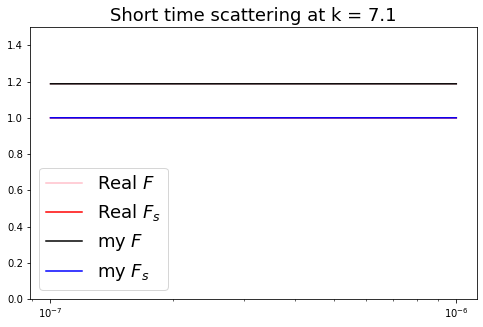

In [12]:
fig = plt.figure(figsize = (8, 5))
fig.add_subplot(1, 1, 1)
plt.semilogx(short_time, realf[0:10], 'pink', label = r'Real $F$');
plt.semilogx(short_time, realfs[0:10], 'red', label = r'Real $F_s$');
plt.semilogx(short_time, pF[0], 'k', label = r'my $F$');
plt.semilogx(short_time, pFs[0], 'b', label = r'my $F_s$');
plt.ylim([0.0, 1.5])
plt.title("Short time scattering at k = 7.1", size = 18)
plt.legend(fontsize = 18);

In [13]:
new_ks, new_Sk, F, Fs = short_scattering(eta, D0, set_of_ks, short_time)

In [14]:
zeta = friction(D0, rho, new_ks, new_Sk, F, Fs, dk)

In [15]:
lamda = 1.0 / (1.0 + (set_of_ks / kc)**2)
alpha_k = 1.0 / ((1.0 / delta_t) + (set_of_ks**2) * D0 * (1.0 / structure_factor) + lamda * zeta[0])
alphas_k = 1.0 / ((1.0 / delta_t) + (set_of_ks**2) * D0 + lamda * zeta[0])

In [16]:
F_100 = np.zeros((F.shape[0], t_steps))
Fs_100 = np.zeros((Fs.shape[0], t_steps))
zeta_100 = np.zeros(t_steps)

F_100[:,:10] = F
Fs_100[:,:10] = Fs
zeta_100[:10] = zeta

for n in range(10, 100): # Time loop
    zeta_100[n] = zeta_100[n - 1]
    error = 1.0
    
    while error > tolerance:
        sum1 = np.zeros(F_100.shape[0])
        sum2 = np.zeros(F_100.shape[0])
        sum1s = np.zeros(F_100.shape[0])
        sum2s = np.zeros(F_100.shape[0])
   
        for i in range(2, (n // 2) + 1):
            sum1 += (zeta_100[n + 1 - i] - zeta_100[n - i]) * F_100[:, i - 1]
            sum2 += zeta_100[i - 1] * (F_100[:, n + 1 - i] - F_100[:, n - i])
            sum1s += (zeta_100[n + 1 - i] - zeta_100[n - i]) * Fs_100[:, i - 1]
            sum2s += zeta_100[i - 1] * (Fs_100[:, n + 1 - i] - Fs_100[:, n - i])
        
        F_100[:, n] = alpha_k * lamda * (zeta_100[n - 1] * F_100[:,0] + zeta_100[0] * F_100[:,n - 1] \
                       - zeta_100[n // 2] * F_100[:, n // 2] - sum1 - sum2) \
                       + (alpha_k / delta_t) * F_100[:, n - 1] + alpha_k * lamda * zeta_100[n] \
                       * (structure_factor - F_100[:, 0])
        Fs_100[:, n] = alphas_k * lamda * (zeta_100[n - 1] * Fs_100[:, 0] + zeta_100[0] * Fs_100[:, n - 1]
                    - zeta_100[n // 2] * Fs_100[:, n // 2] - sum1s - sum2s) \
                    + (alphas_k / delta_t) * Fs_100[:, n - 1] + alphas_k * lamda * zeta_100[n] \
                    * (1.0 - Fs_100[:, 0])
        
        new_zeta = friction(D0, rho, set_of_ks, structure_factor, F_100[:, n], Fs_100[:, n], dk)
        error = abs((zeta_100[n] - new_zeta) / new_zeta)
        zeta_100[n] = new_zeta

El problema podría estar en mi manejo de los índices. Las fórmulas asumen que mis índices empiezan en 1, cuando en realidad empiezan en cero. Tal vez no estoy adaptando bien mi desmadre.

In [17]:
total_time = np.loadtxt('Fs2compare.dat', usecols = 0)

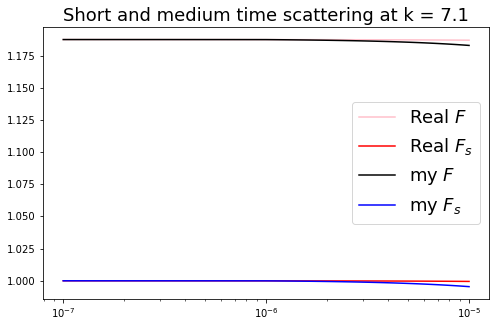

In [18]:
fig = plt.figure(figsize = (8, 5))
fig.add_subplot(1, 1, 1)
plt.semilogx(total_time, realf, 'pink', label = r'Real $F$');
plt.semilogx(total_time, realfs, 'red', label = r'Real $F_s$');
plt.semilogx(total_time, F_100[709], 'k', label = r'my $F$');
plt.semilogx(total_time, Fs_100[709], 'b', label = r'my $F_s$');
plt.title("Short and medium time scattering at k = 7.1", size = 18)
plt.legend(fontsize = 18);

In [19]:
real_zeta = np.loadtxt('Fself.dat', usecols = 3)

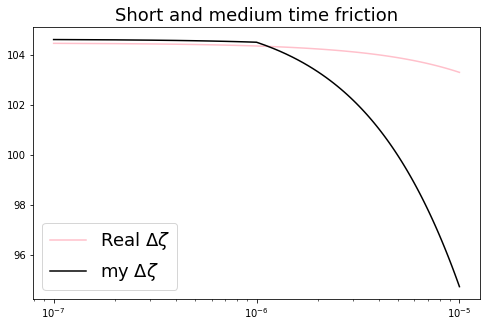

In [20]:
fig = plt.figure(figsize = (8, 5))
fig.add_subplot(1, 1, 1)
plt.semilogx(total_time, real_zeta, 'pink', label = r'Real $\Delta\zeta$');
plt.semilogx(total_time, zeta_100, 'k', label = r'my $\Delta\zeta$');
plt.title("Short and medium time friction", size = 18)
plt.legend(fontsize = 18);